Global mantle convection simulation with sequentially imposed GPlates surface velocities
========================================================================================

In this tutorial, we transition from our idealised 3-D spherical
shell geometry simulation to a scenario where surface velocities
from a plate reconstruction model are used as the top-surface
velocity boundary condition.  This type of simulation has been
extensively used over recent decades to study the spatial and
temporal evolution of mantle flow.  This tutorial builds on the
*idealised 3-D spherical shell geometry simulation* and a user
should follow that tutorial prior to this.

This example focuses on:
1. How to import GPlates functionalities into G-ADOPT. For being
   able to import gadopt.gplates module you need to have a working
   pyGPlates.  For more information on how to build pyGPlates see
   [EarthByte's
   page](https://www.earthbyte.org/category/resources/software-workflows/pygplates/).
2. How to set prescribed boundary conditions.
3. How to configure nullspaces in a setup where there are
   constraints on tangential velocities at the surface.
4. How to load a 1-D radial profile from a file (here, to prescribe
   a spherically symmetric viscosity)

Aside from these aspects, the case closely follows the previous 3-D
spherical example.

Let's begin with the usual import of G-ADOPT, set up of the mesh,
function spaces, functions to hold our solutions, material
properties, approximations and initial conditions:

Note that sometimes we get a confusing `SyntaxWarning` during the
set up. This is due to the pyGPlates module itself, but doesn't
affect any functionality and is safe to ignore.

In [1]:
from gadopt import *
from gadopt.gplates import *
import scipy.special
import math
rmin, rmax, ref_level, nlayers = 1.208, 2.208, 4, 8

mesh2d = CubedSphereMesh(rmin, refinement_level=ref_level, degree=2)
mesh = ExtrudedMesh(mesh2d, layers=nlayers, extrusion_type="radial")
mesh.cartesian = False
boundary = get_boundary_ids(mesh)

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

time = 0.0  # Initial time
delta_t = Constant(1e-6)  # Initial time-step
timesteps = 5  # Maximum number of timesteps
t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)

T = Function(Q, name="Temperature")
T_avg = Function(Q, name="Layer_Averaged_Temp")
T_dev = Function(Q, name="Temperature_Deviation")

X = SpatialCoordinate(mesh)
r = sqrt(X[0]**2 + X[1]**2 + X[2]**2)
theta = atan2(X[1], X[0])  # Theta (longitude - different symbol to Zhong)
phi = atan2(sqrt(X[0]**2+X[1]**2), X[2])  # Phi (co-latitude - different symbol to Zhong)

conductive_term = rmin*(rmax - r) / (r*(rmax - rmin))
l, m, eps_c, eps_s = 3, 2, 0.01, 0.01
Plm = Function(Q, name="P_lm")
cos_phi = Function(Q, name="cos_phi").interpolate(cos(phi))
Plm.dat.data[:] = scipy.special.lpmv(m, l, cos_phi.dat.data_ro)  # Evaluate P_lm node-wise using scipy lpmv
Plm.assign(Plm*math.sqrt(((2*l+1)*math.factorial(l-m))/(2*math.pi*math.factorial(l+m))))
if m == 0:
    Plm.assign(Plm/math.sqrt(2))
T.interpolate(conductive_term +
              (eps_c*cos(m*theta) + eps_s*sin(m*theta)) * Plm * sin(pi*(r - rmin)/(rmax-rmin)))

averager = LayerAveraging(mesh, quad_degree=6)
averager.extrapolate_layer_average(T_avg, averager.get_layer_average(T))

## Loading a 1-D Axisymmetric Profile for Viscosity

Earth's physical properties are primarily characterised by
spherically symmetric (depth-dependent) features influenced
predominantly by hydrostatic pressure variations. Here, we load a
1-D viscosity profile, as utilised by Ghelichkhan et al. (2021) in
*Geophysical Journal International* to model Earth's evolution
during the Cenozoic era. We first set up our viscosity function
space. The 1-D profile data is located in the file
`./mu2_radial.rad`, and we will use interpolation functionalities
provided by G-ADOPT to populate the viscosity field.

This expression generates a warning from TSFC, the Two-Stage Form
Compiler. The underlying interpolation routine on a non-Cartesian
geometry hits an edge case in the form optimisation, but this can
safely be ignored.

In [2]:
mu = Function(Q, name="Viscosity")
interpolate_1d_profile(function=mu, one_d_filename="mu2_radial.rad")

tsfc:WARNING Estimated quadrature degree 22 more than tenfold greater than any argument/coefficient degree (max (2, 1))


tsfc:WARNING Estimated quadrature degree 22 more than tenfold greater than any argument/coefficient degree (max (2, 1))


tsfc:WARNING Estimated quadrature degree 22 more than tenfold greater than any argument/coefficient degree (max (2, 1))


Now that we have the viscosity profile we can pass this to our
approximation.

In [3]:
Ra = Constant(7e3)  # Rayleigh number
approximation = BoussinesqApproximation(Ra, mu=mu)

## Nullspaces:

Our idealised 3-D spherical case had free-slip velocity boundary
conditions at both top and bottom surfaces.  With those boundary
conditions, the velocity component of the Stokes equation entails
three rotational nullspaces in all three rotational directions. In
the example considered herein, we impose the surface velocity as
prescribed by a plate tectonic reconstructions and, hence, there is
no longer a rotational nullspace. Accordingly, we set the
`rotational` argument to `False` when creating the Z_nullspace
object.

In [4]:
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=False)
Z_near_nullspace = create_stokes_nullspace(Z, closed=False, rotational=True, translations=[0, 1, 2])

Notice that near nullspaces remain consistent with the idealised 3-D
spherical example, as they are a key aspect of our preconditioning
approach.

## pyGPlates interface in G-ADOPT

Next, we define the surface velocities. All GPlates functionalities
are accessible through the module `gadopt.gplates`. We will use the
interface provided by G-ADOPT for pyGPlates. Similar to pyGPlates,
the G-ADOPT interface requires specific files for loading and
processing surface velocities from a reconstruction model. For this
tutorial, we will use the study published by Muller et al., 2022.
The files can be downloaded from EarthByte's server at:
https://earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2022_SE/Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2.zip
Download and unzip this file into the current
directory. Below, we verify the required paths in this directory and
ensure they exist:

In [5]:
muller_2022_files = ensure_reconstruction("Muller 2022 SE v1.2", ".")

In [6]:
# These are the files that needs to be passed on to pyGPlates
print(muller_2022_files)

{'rotation_filenames': ['Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2/optimisation/1000_0_rotfile_MantleOptimised.rot'], 'topology_filenames': ['Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2/250-0_plate_boundaries.gpml', 'Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2/410-250_plate_boundaries.gpml', 'Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2/1000-410-Convergence.gpml', 'Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2/1000-410-Divergence.gpml', 'Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2/1000-410-Topologies.gpml', 'Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2/1000-410-Transforms.gpml']}


To generate a pyGplatesConnector in G-ADOPT, you need to provide the
necessary rotation and topology files.  These files describe the
plate polygons and their association with the Euler rotation poles
at each stage of the reconstruction.  Additionally, you need to
specify the oldest available age in the model, which for the
reconstruction considered here is a billion years.  There are
optional arguments with default values that can affect how the
surface velocities are reconstructed.  `nseeds` is the number of
points on a sphere used to initially load the plate reconstruction
data, and `nneighbours` is the number of nearest points used to
interpolate from the seed points to our 3-D mesh.  A lower `nseeds *
1/nneighbours` ratio results in a smoother velocity representation
at each age, and vice versa.  This is especially useful for
simulations on coarser grids. Given that this tutorial considers a
Rayleigh number several orders of magnitude lower than Earth's
mantle, we also scale plate velocities using an optional
scaling_factor.

In [7]:
plate_reconstruction_model = pyGplatesConnector(
    rotation_filenames=muller_2022_files["rotation_filenames"],
    topology_filenames=muller_2022_files["topology_filenames"],
    oldest_age=1000,
    nseeds=1e5,
    nneighbours=4,
    delta_t=0.9,
    scaling_factor=1000.
)

A plate reconstruction model includes an essential feature for
simulations of Earth's mantle in which the distribution of
heterogeneity is principally dictated by plate boundaries.This
feature depends on the imported data through the plate
reconstruction and allows for conversions between *time*
(non-dimensional time here) and geologic *age*. To achieve this, you
can use `age2ndtime` and `ndtime2age`.

For example, the starting time (zero time) and present-day time (zero age) are:

In [8]:
log(f"Oldest age is {plate_reconstruction_model.ndtime2age(0.0)} Ma")
log(f"Non-dimensionalised present-day time: {plate_reconstruction_model.age2ndtime(0.0)}")

Oldest age is 1000.0 Ma
Non-dimensionalised present-day time: 3.7758168604303113


With the plate reconstruction model loaded using
`pyGplatesConnector``, we can now generate the velocity field.  This
is done using `GplatesVelocityFunction`. For all practical purposes,
it behaves as a UFL-compatible Function. However, defining it
requires two additional arguments. One is the `gplates_connector`,
which we defined above, and the second is the subdomain marker of
the top boundary in the mesh. Other arguments are identical to a
Firedrake Function, meaning at minimum a FunctionSpace should be
provided for the Function, which here is `V`, and optionally a name
for the function.

In [9]:
# Top velocity boundary condition
gplates_velocities = GplatesVelocityFunction(
    V,
    gplates_connector=plate_reconstruction_model,
    top_boundary_marker=boundary.top,
    name="GPlates_Velocity"
)

Once this is defined, we can use
`gplates_velocities.update_plate_reconstruction(time)` to update the
velocity function to a new time. Note that time is
non-dimensional. Since `GplatesVelocityFunction` is a Firedrake
function for all purposes, it can be easily viewed using VTK
functionalities in Firedrake.

pyGplates: Updating surface velocities for 200.00 Ma.


pyGplates: Updating surface velocities for 100.00 Ma.


/__w/g-adopt/g-adopt/.venv/lib/python3.12/site-packages/gadopt/gplates/gplates.py:453: RuntimeWarning: pygplates couldn't assign plate IDs to some seeds due to irregularities in the reconstruction model. G-ADOPT will interpolate the nearest values.
  warnings.warn("pygplates couldn't assign plate IDs to some seeds due to irregularities in the reconstruction model. G-ADOPT will interpolate the nearest values.", category=RuntimeWarning)


pyGplates: Updating surface velocities for 0.00 Ma.


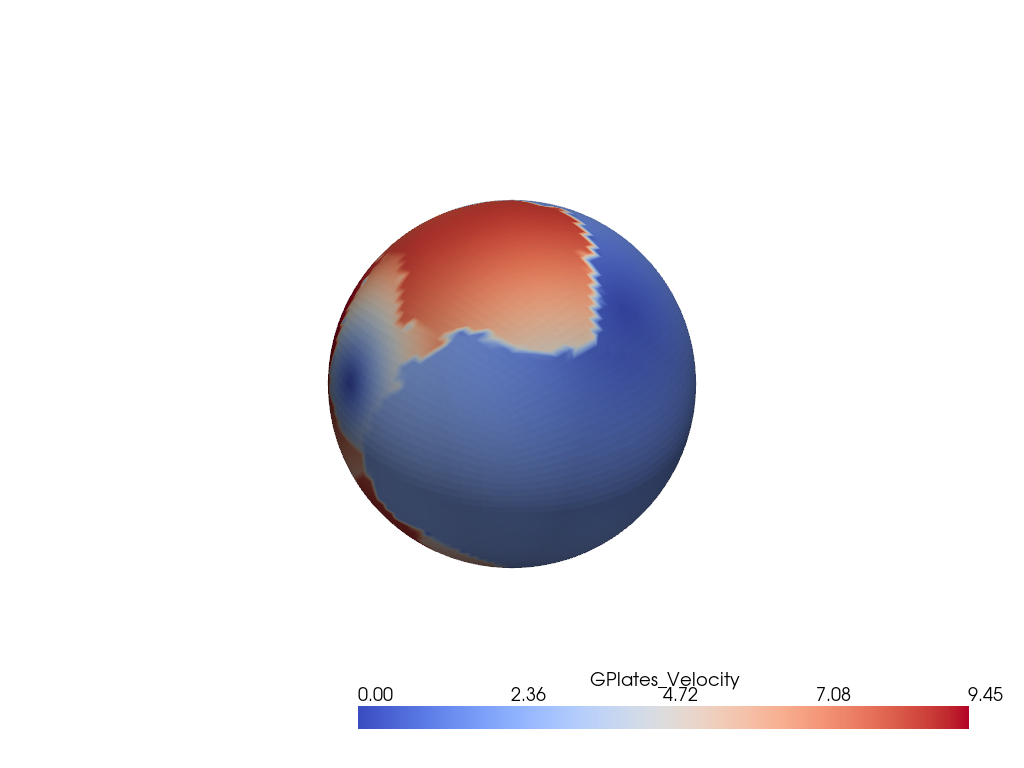

In [10]:
vtk_file = VTKFile("gplates_velocity.pvd")
for mytime in [200, 100, 0]:
    gplates_velocities.update_plate_reconstruction(ndtime=plate_reconstruction_model.age2ndtime(mytime))
    vtk_file.write(gplates_velocities)

import pyvista as pv
import os
dataset = pv.read("gplates_velocity/gplates_velocity_0.vtu")

# Create a plotter object
plotter = pv.Plotter()
# Whether our plot should be interactive or not
backend = None
if os.environ.get("GADOPT_RENDER", "false").lower() == "true":
    backend = "static"
# Add the dataset to the plotter
plotter.add_mesh(dataset, scalars="GPlates_Velocity", cmap="coolwarm")
glyphs = dataset.glyph(orient="GPlates_Velocity", scale=1, factor=1e-4)
# Add glyphs to the plotter
plotter.add_mesh(glyphs, color="black", opacity=0.2)
# Adjust the camera position
plotter.camera_position = [(10.0, 10.0, 10.0), (0.0, 0.0, 0), (0, 1, 0)]
# Show the plot
plotter.show(jupyter_backend=backend)

And last but not least, we need to inform our solver of our choice
of boundary conditions. This is done by adding it to the
`stokes_bcs` dictionary. From there to the end of the simulation,
everything works seamlessly by updating `gplates_velocities` via a
call to `gplates_velocities.update_plate_reconstruction(time)`
within the time loop.

In [11]:
stokes_bcs = {
    boundary.bottom: {'un': 0},
    boundary.top: {'u': gplates_velocities},
}

temp_bcs = {
    boundary.bottom: {'T': 1.0},
    boundary.top: {'T': 0.0},
}

output_file = VTKFile("output.pvd")
output_frequency = 1

plog = ParameterLog("params.log", mesh)
plog.log_str("timestep time age dt maxchange u_rms u_rms_top nu_top nu_base energy avg_t")

gd = GeodynamicalDiagnostics(z, T, boundary.bottom, boundary.top, quad_degree=6)

energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

stokes_solver = StokesSolver(
    z,
    T,
    approximation,
    bcs=stokes_bcs,
    constant_jacobian=True,
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace,
    near_nullspace=Z_near_nullspace,
)

Before we begin with the time-stepping, we need to know when to
stop, which is when we arrive at the present-day.  To achieve this,
we define `presentday_ndtime` which tells us when the simulation
should end.  Note that this tutorial terminates after reaching a
specified number of timesteps, prior to reaching the present-day.

In [12]:
presentday_ndtime = plate_reconstruction_model.age2ndtime(0.0)

for timestep in range(0, timesteps):

    # Write output:
    if timestep % output_frequency == 0:
        # Compute radially averaged temperature profile as simulation evolves.
        averager.extrapolate_layer_average(T_avg, averager.get_layer_average(T))
        # Compute deviation from layer average
        T_dev.assign(T-T_avg)
        # Output fields, including viscosity
        output_file.write(*z.subfunctions, T, T_dev, mu)

    if timestep != 0:
        dt = t_adapt.update_timestep()
    else:
        dt = float(delta_t)
    time += dt

    # Update plate velocities:
    gplates_velocities.update_plate_reconstruction(time)

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    nusselt_number_top = gd.Nu_top() * (rmax*(rmin-rmax)/rmin) * -1.
    nusselt_number_base = gd.Nu_bottom() * (rmin*(rmax-rmin)/rmax)
    energy_conservation = abs(abs(nusselt_number_top) - abs(nusselt_number_base))

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((T - energy_solver.T_old)**2 * dx))

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {plate_reconstruction_model.ndtime2age(time)} {float(delta_t)} "
                 f"{maxchange} {gd.u_rms()} {gd.u_rms_top()} "
                 f"{nusselt_number_top} {nusselt_number_base} "
                 f"{energy_conservation} {gd.T_avg()} ")

    # Do not go over present-day
    if time > presentday_ndtime:
        break

pyGplates: Updating surface velocities for 1000.00 Ma.


pyGplates: Updating surface velocities for 1000.00 Ma.


pyGplates: Updating surface velocities for 1000.00 Ma.


pyGplates: Updating surface velocities for 1000.00 Ma.


pyGplates: Updating surface velocities for 1000.00 Ma.


At the end of the simulation, once a steady-state has been achieved,
we close our logging file and checkpoint steady state temperature
and Stokes solution fields to disk. These can later be used to
restart a simulation, if required.

In [13]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")